# Fake News Detection Demo Notebook
This notebook demonstrates various machine learning approaches for detecting fake news, from traditional ML to state-of-the-art transformers.

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pickle
import time
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import HTML, display
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Load Models

In [3]:
# model loading with progress indicators
class ModelLoader:
    def __init__(self):
        self.models = {}
        self.tokenizers = {}
        self.vectorizer = None
        
    def load_all_models(self):
        """Load all available models with visual progress."""
        model_configs = [
            ('Logistic Regression', self._load_traditional, '🔢'),
            ('TinyBERT', self._load_tinybert, '🐤'),
            ('MobileBERT', self._load_mobilebert, '📱'),
            ('DistilBERT', self._load_distilbert, '⚡'),
            ('ALBERT', self._load_albert, '🧠')
        ]
        
        for name, loader, icon in model_configs:
            print(f"{icon} Loading {name}...", end=' ')
            try:
                loader()
                print("✅ Success!")
            except Exception as e:
                print(f"❌ Not available")
    
    def _load_traditional(self):
        with open('../ml_models/baseline/lr_text_model.pkl', 'rb') as f:
            self.models['lr'] = pickle.load(f)
        with open('../ml_models/baseline/tfidf_vectorizer.pkl', 'rb') as f:
            self.vectorizer = pickle.load(f)
    
    def _load_tinybert(self):
        path = '../ml_models/tinybert_welfake_model'
        self.tokenizers['tinybert'] = AutoTokenizer.from_pretrained(path)
        self.models['tinybert'] = AutoModelForSequenceClassification.from_pretrained(path)
        self.models['tinybert'].eval()
    
    def _load_mobilebert(self):
        path = '../ml_models/mobilebert_welfake_model'
        self.tokenizers['mobilebert'] = AutoTokenizer.from_pretrained(path)
        self.models['mobilebert'] = AutoModelForSequenceClassification.from_pretrained(path)
        self.models['mobilebert'].eval()
    
    def _load_distilbert(self):
        path = '../ml_models/distilbert_welfake_model'
        self.tokenizers['distilbert'] = AutoTokenizer.from_pretrained(path)
        self.models['distilbert'] = AutoModelForSequenceClassification.from_pretrained(path)
        self.models['distilbert'].eval()
    
    def _load_albert(self):
        path = '../ml_models/albert_welfake_model'
        self.tokenizers['albert'] = AutoTokenizer.from_pretrained(path)
        self.models['albert'] = AutoModelForSequenceClassification.from_pretrained(path)
        self.models['albert'].eval()

# Load all models
loader = ModelLoader()
loader.load_all_models()

🔢 Loading Logistic Regression... ✅ Success!
✅ Success! TinyBERT... 
✅ Success! MobileBERT... 
⚡ Loading DistilBERT... ✅ Success!
🧠 Loading ALBERT... ✅ Success!


## 3. Prediction Functions

In [4]:
# Cell 4: prediction functions
class FakeNewsDetector:
    def __init__(self, model_loader):
        self.loader = model_loader
        
    def predict_all(self, text):
        """Get predictions from all available models."""
        results = []
        
        # Traditional ML
        if 'lr' in self.loader.models:
            result = self._predict_traditional(text)
            if result:
                results.append(result)
        
        # Transformers
        for model_name in ['tinybert', 'mobilebert', 'distilbert', 'albert']:
            if model_name in self.loader.models:
                result = self._predict_transformer(text, model_name)
                if result:
                    results.append(result)
        
        return pd.DataFrame(results)
    
    def _predict_traditional(self, text):
        """Traditional ML prediction."""
        start = time.time()
        X = self.loader.vectorizer.transform([text])
        pred = self.loader.models['lr'].predict(X)[0]
        prob = self.loader.models['lr'].predict_proba(X)[0]
        time_ms = (time.time() - start) * 1000
        
        return {
            'Model': 'Logistic Regression',
            'Prediction': '🚫 FAKE' if pred == 1 else '✅ REAL',
            'Confidence': f'{prob.max():.1%}',
            'Time (ms)': f'{time_ms:.1f}',
            'Type': 'Traditional ML'
        }
    
    def _predict_transformer(self, text, model_name):
        """Transformer prediction."""
        model = self.loader.models[model_name]
        tokenizer = self.loader.tokenizers[model_name]
        
        start = time.time()
        inputs = tokenizer(text, return_tensors="pt", truncation=True, 
                          padding=True, max_length=512)
        
        with torch.no_grad():
            outputs = model(**inputs)
            pred = torch.argmax(outputs.logits, dim=1).item()
            probs = torch.softmax(outputs.logits, dim=1)
            conf = probs.max().item()
        
        time_ms = (time.time() - start) * 1000
        
        model_display = {
            'tinybert': 'TinyBERT',
            'mobilebert': 'MobileBERT',
            'distilbert': 'DistilBERT',
            'albert': 'ALBERT'
        }
        
        return {
            'Model': model_display[model_name],
            'Prediction': '🚫 FAKE' if pred == 1 else '✅ REAL',
            'Confidence': f'{conf:.1%}',
            'Time (ms)': f'{time_ms:.1f}',
            'Type': 'Transformer'
        }

# Create detector
detector = FakeNewsDetector(loader)

## 4. Interactive Demo

In [26]:
# Cell 5: Visual article analysis
def analyze_article(text, title="Article Analysis"):
    """Analyze article with visual presentation."""
    # Get predictions
    results = detector.predict_all(text)
    
    if not results.empty:
        # Style the results table
        styled_results = results.style.set_properties(**{
            'text-align': 'center',
            'font-size': '14px'
        }).set_table_styles([
            {'selector': 'th', 'props': [('background-color', '#3498db'), 
                                         ('color', 'white'), 
                                         ('font-weight', 'bold')]}
        ])
        display(styled_results)
        
        # Create consensus visualization
        fake_count = sum(1 for pred in results['Prediction'] if 'FAKE' in pred)
        real_count = len(results) - fake_count
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Consensus pie chart
        ax1.pie([real_count, fake_count], labels=['Real', 'Fake'], 
                colors=['#2ecc71', '#e74c3c'], autopct='%1.0f%%',
                startangle=90)
        ax1.set_title('Model Consensus')
        
        # Inference time comparison
        results_copy = results.copy()
        results_copy['Time_float'] = results_copy['Time (ms)'].str.replace(' ms', '').astype(float)
        colors = ['#3498db' if t == 'Traditional ML' else '#9b59b6' for t in results_copy['Type']]
        ax2.bar(results_copy['Model'], results_copy['Time_float'], color=colors)
        ax2.set_ylabel('Inference Time (ms)')
        ax2.set_title('Speed Comparison')
        ax2.set_yscale('log')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()

## 6. Test Examples

📰 Example 1: Real News


,Model,Prediction,Confidence,Time (ms),Type
0,Logistic Regression,✅ REAL,78.2%,2.5,Traditional ML
1,TinyBERT,✅ REAL,100.0%,21.5,Transformer
2,MobileBERT,✅ REAL,95.3%,45.9,Transformer
3,DistilBERT,✅ REAL,100.0%,22.9,Transformer
4,ALBERT,✅ REAL,100.0%,48.3,Transformer


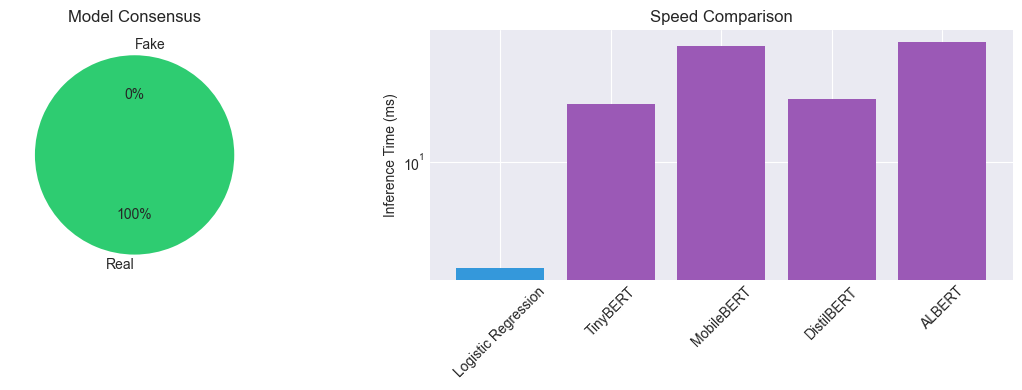

In [39]:
# Cell 6: Test with examples
# Example 1: Real news
real_news = """
Russia launches war's largest air attack on Ukraine, kills at least 12 people
Russian forces launched a barrage of 367 drones and missiles at Ukrainian 
cities overnight, including the capital Kyiv, in the largest aerial attack of the war so far, killing 
at least 12 people and injuring dozens more, officials said.
The dead included three children in the northern region of Zhytomyr, local officials there said.
"""

print("📰 Example 1: Real News")
analyze_article(real_news, "Real News Example")


📰 Example 2: Fake News


,Model,Prediction,Confidence,Time (ms),Type
0,Logistic Regression,🚫 FAKE,99.1%,3.0,Traditional ML
1,TinyBERT,🚫 FAKE,100.0%,17.6,Transformer
2,MobileBERT,🚫 FAKE,100.0%,54.8,Transformer
3,DistilBERT,🚫 FAKE,100.0%,21.2,Transformer
4,ALBERT,🚫 FAKE,100.0%,43.0,Transformer


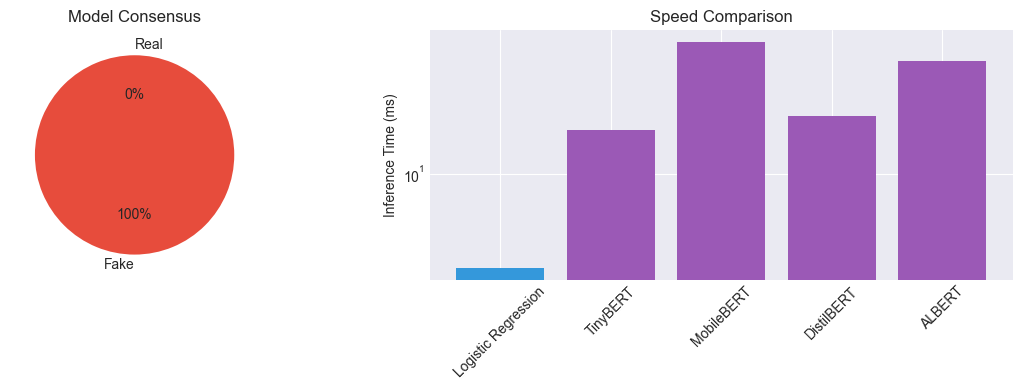

In [28]:
# Cell 7: Fake news example
fake_news = """
BREAKING: Scientists at Harvard have discovered that eating chocolate before bed 
increases IQ by 20 points! This SHOCKING discovery is being SUPPRESSED by the 
education industry. Share this before it gets DELETED! Studies show 100% success rate. 
Big Pharma doesn't want you to know this ONE SIMPLE TRICK!
"""

print("\n📰 Example 2: Fake News")
analyze_article(fake_news, "Fake News Example")

## 7. LIME Explainability

🔍 Explainability Analysis


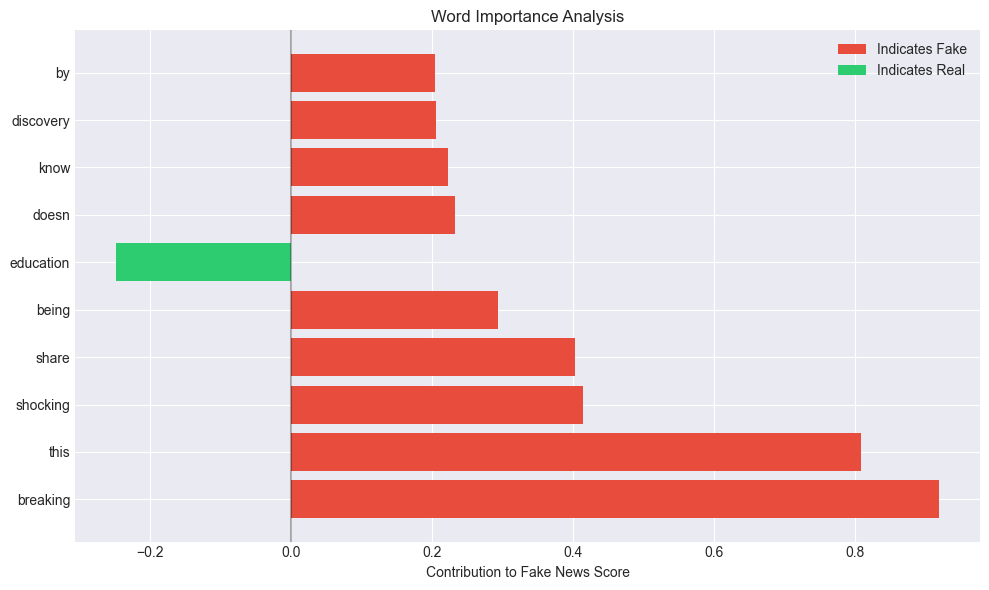

In [10]:
# Cell 8: LIME explanation (simplified version)
def explain_prediction(text, model_name='lr'):
    """Show which words contributed to the prediction."""
    if model_name == 'lr' and 'lr' in loader.models:
        # Get TF-IDF features
        X = loader.vectorizer.transform([text])
        feature_names = loader.vectorizer.get_feature_names_out()
        
        # Get model coefficients
        coef = loader.models['lr'].coef_[0]
        
        # Get top contributing words
        tfidf_scores = X.toarray()[0]
        word_contributions = tfidf_scores * coef
        
        # Get top positive and negative contributors
        top_indices = np.argsort(np.abs(word_contributions))[-10:][::-1]
        
        # Create visualization
        fig, ax = plt.subplots(figsize=(10, 6))
        
        words = [feature_names[i] for i in top_indices]
        scores = [word_contributions[i] for i in top_indices]
        colors = ['#e74c3c' if s > 0 else '#2ecc71' for s in scores]
        
        bars = ax.barh(words, scores, color=colors)
        ax.set_xlabel('Contribution to Fake News Score')
        ax.set_title(f'Word Importance Analysis')
        ax.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        
        # Add legend
        red_patch = plt.Rectangle((0,0),1,1, fc='#e74c3c')
        green_patch = plt.Rectangle((0,0),1,1, fc='#2ecc71')
        ax.legend([red_patch, green_patch], ['Indicates Fake', 'Indicates Real'], 
                 loc='best')
        
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ LIME explanation only available for Logistic Regression model")

# Example usage
print("🔍 Explainability Analysis")
explain_prediction(fake_news)

## 9. Interactive Demo

,Model,Prediction,Confidence,Time (ms),Type
0,Logistic Regression,✅ REAL,92.5%,2.9,Traditional ML
1,TinyBERT,✅ REAL,100.0%,21.0,Transformer
2,MobileBERT,✅ REAL,100.0%,81.7,Transformer
3,DistilBERT,✅ REAL,100.0%,29.4,Transformer
4,ALBERT,✅ REAL,100.0%,71.1,Transformer


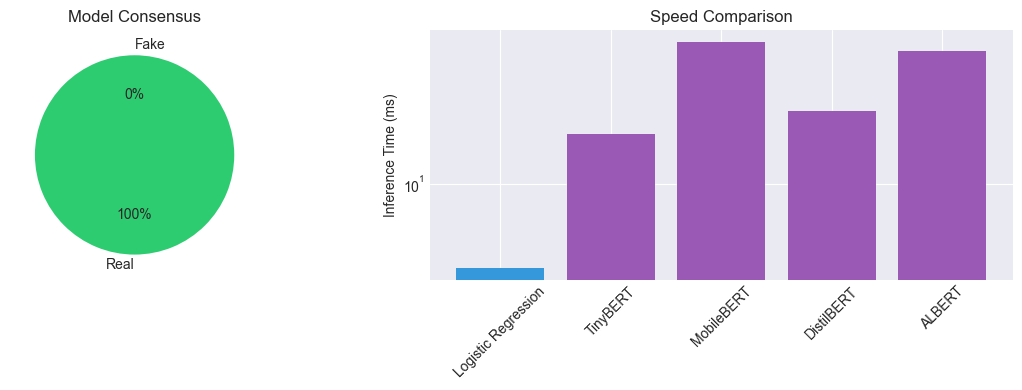

In [29]:
custom_text = """
Oracle to buy $40 billion of Nvidia chips for OpenAI's US data center, FT reports
May 23 (Reuters) - Oracle (ORCL.N), will spend around $40 billion on Nvidia's (NVDA.O),
higher-performance chips to power OpenAI's new U.S. data center, the Financial Times reported on Friday.
The data center, situated in Abilene, Texas, is part of the U.S. Stargate Project, led by top AI firms
in the country, to boost America's heft in the artificial intelligence industry amid heating global competition.
"""

analyze_article(custom_text, "Article Analysis")

In [ ]:
custom_text = """
Oracle to buy $40 billion of Nvidia chips for OpenAI's US data center, FT reports
May 23 (Reuters) - Oracle (ORCL.N), will spend around $40 billion on Nvidia's (NVDA.O),
higher-performance chips to power OpenAI's new U.S. data center, the Financial Times reported on Friday.
The data center, situated in Abilene, Texas, is part of the U.S. Stargate Project, led by top AI firms
in the country, to boost America's heft in the artificial intelligence industry amid heating global competition.
"""

analyze_article(custom_text, "Article Analysis")